# load data and do elementary calculations and plots

---

In [1]:
import os
import numpy as np
import dask
import xarray as xr
from dask import compute, delayed
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
dmethod = 1
#
if dmethod == 1:
    from dask.distributed import Client
    scheduler = os.getenv('DATAWORK')+'/dask/scheduler.json'
    client = Client(scheduler_file=scheduler)
elif dmethod == 2:
    from dask_jobqueue import PBSCluster
    # folder where data is spilled when RAM is filled up
    local_dir = os.getenv('TMPDIR')
    #
    cluster = PBSCluster(queue='mpi_1', local_directory=local_dir, interface='ib0', walltime='24:00:00',
                         threads=14, processes=2, memory='50GB', resource_spec='select=1:ncpus=28:mem=100g', 
                         death_timeout=100)
    w = cluster.start_workers(40)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# you need to wait for workers to spin up
if dmethod == 2:
    cluster.scheduler

In [4]:
# get dask handles and check dask server status
if dmethod == 2:
    from dask.distributed import Client
    client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.148.0.49:8786 Dashboard: http://10.148.0.49:8787/status,Cluster Workers: 7 Cores: 98 Memory: 700.00 GB


In [6]:
data_dir = '/home/datawork-lops-osi/data/mit4320/Eta/'
grid_dir = '/home/datawork-lops-osi/data/mit4320/grid/'

iters, time = get_iters_time('Eta', data_dir, delta_t=25.)

ds = get_compressed_data('Eta', data_dir, grid_dir, iters=iters, time=time, client=None)
#ds = get_compressed_data('Eta', data_dir, grid_dir, iters=iters, time=time, client=client)
ds = ds.chunk({'face': 1})
print(ds)
print('\n data size: %.1f GB' %(ds['Eta'].nbytes / 1e9))
print('\n data size (1 face): %.1f GB' %(ds['Eta'].isel(face=1).nbytes / 1e9))

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:721: UserWarning: Couldn't find available_diagnostics.log in . Using default version.
  "in %s. Using default version." % data_dir)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 4096)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(

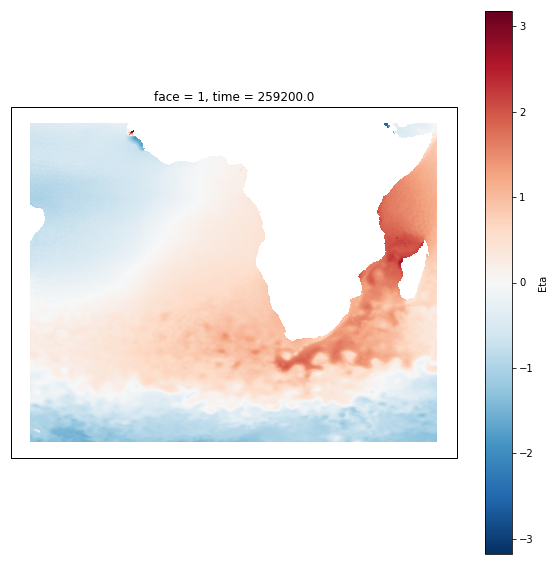

In [7]:
# plot one figure to check lon/lat treatment
import cartopy.crs as ccrs
eta = ds['Eta'].isel(face=1, time=0)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
eta.plot(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree())
#

---

# make movie

 Method 1: data is loaded locally by each worker


In [8]:
face = 1
vmin = -2.5
vmax = 2.5

#delete all figures beforehand
figdir = os.getenv('DATAWORK')+'/mit/figs/'
print(figdir)

def process(iters, time, i,  overwrite=True):
    
    ds = get_compressed_data('Eta', data_dir, grid_dir, iters=iters, time=time, client=None)
    
    eta = ds['Eta'].isel(face=face, time=0)

    # eta = eta.isel(i=slice(0,100),j=slice(0,100))

    #time = pd.to_datetime(str(eta['time'].values))
    time = eta['time'].values/86400.
    figname = figdir+'mit_eta_f%d_t%05d' %(face, i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #
        title = 'eta %.2f' %time
        plot_scalar(eta, colorbar=False, title=title, savefig=figname, vmin=vmin, vmax=vmax, 
                    offline=True, coast_resolution='50m', figsize=(15,10), cmmap='balance')
        #
        m = float(eta.mean().values)
    else:
        m = -1.
    return m

I = range(len(ds['time']))
I = range(100)
values = [delayed(process)(iters.isel(time=slice(i,i+1)), time.isel(iters=slice(i,i+1)), i) for i in I]

/home1/datawork/aponte/mit/figs/


In [9]:
%time results = compute(*values, get=client.get)

CPU times: user 684 ms, sys: 48 ms, total: 732 ms
Wall time: 6min 37s


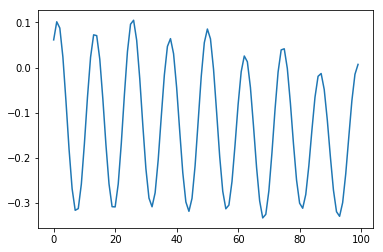

In [10]:
plt.plot(np.array(results))

---

# method 2 (fails):

Try to use the dataset loaded initially

This method fails with not various error messages.
Workers may be running out of memory

In [9]:
face = 1
vmin = -2.
vmax = 2.

#delete all figures beforehand
figdir = os.getenv('DATAWORK')+'/mit/figs/'
print(figdir)

def process(eta, i, overwrite=True):
    
    # eta = eta.isel(i=slice(0,100),j=slice(0,100))

    #time = pd.to_datetime(str(eta['time'].values))
    time = eta['time'].values/86400.
    figname = figdir+'mit_eta_f%d_t%05d' %(face, i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #
        title = 'eta %.2f' %time
        #plot_scalar(eta, colorbar=False, title=title, savefig=figname, vmin=vmin, vmax=vmax, 
        #         offline=True, coast_resolution='50m', figsize=(15,10))
        #
        m = float(eta.mean().values)
    else:
        m = -1.
    return m

I = range(len(ds['time']))
I = range(100)
values = [delayed(process)(ds['Eta'].isel(face=face, time=i), i) for i in I]

/home1/datawork/aponte/mit/figs/


In [ ]:
%time results = compute(*values, get=client.get)

---

# info, shutdown

In [21]:
client.restart()

Client Scheduler: tcp://10.148.0.49:8786 Dashboard: http://10.148.0.49:8787/status,Cluster Workers: 7 Cores: 98 Memory: 700.00 GB


In [ ]:
if dmethod == 2:
    client.close()
    cluster.stop_workers(cluster.jobs)